# Latent space vizualization


In [2]:
import json
import integrated_cell
from integrated_cell import model_utils, utils
import os
import numpy as np
import torch

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from integrated_cell.utils.plots import tensor2im, imshow

gpu_ids = [3]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()
    
#load the reference model
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'

ref_model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04'
ref_suffix = '_94544'    

networks, dp_ref, args_ref = utils.load_network_from_dir(ref_model_dir, parent_dir, suffix=ref_suffix)

ref_enc = networks['enc']
ref_dec = networks['dec']

#load the target model
target_model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/"
target_suffix = '_93300'

networks, dp_target, args_target = utils.load_network_from_dir(target_model_dir, parent_dir, suffix=target_suffix)
    
target_enc = networks['enc']
target_dec = networks['dec']


results_dir = '{}/results/latent_space_vizualization/'.format(parent_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
print("Results dir: {}".format(results_dir))

save_dir = results_dir

recon_loss = utils.load_losses(args_target)['crit_recon']

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth
Results dir: /allen/aics/modeling/gregj/results/integrated_cell//results/latent_space_vizualization/


## Get metadata for all splits

In [107]:
dfs_split = {
    split: pd.concat(
        [
            dp_ref.csv_data.loc[
                dp_ref.data[split]["inds"],
                ["CellId", "PlateId", "CellIndex", "StructureDisplayName"]
            ].reset_index(
            ).rename(
                columns={"index":"UnsplitCsvIndex"}
            ),
            pd.DataFrame({"split":[split]*len(dp_ref.data[split]["inds"])})
        ],
        axis=1
    ) for split in dp_ref.data.keys()
}

## Get mito annotations for each split

In [8]:
# from integrated_cell.utils.utils import save_load_mitosis_annotations
# mito_annots = save_load_mitosis_annotations(dp_ref, save_dir=None)

In [77]:
dfs_mito = {
    split: pd.DataFrame(
        {
            feat:dp_ref.data["test"][feat] for feat in ["inds", "CellId", "mito_state_resolved"]
        }
    ).rename(
        columns={"inds":"UnsplitCsvIndex"}
    ) for split in dp_ref.data.keys()
}

## Get features for all splits together (unsplit df)

In [255]:
import pandas as pd

with open('/raid/shared/ipp/scp_19_04_10/feats_out_with_units.json') as f:
    feats = json.load(f)

df_feats_all = pd.DataFrame.from_dict(feats["rows_with_units"])
my_feats = ["CellId", "dna_volume", "cell_volume"]
df_feats = df_feats_all[my_feats].copy()

In [256]:
df_feats["cell_height"] = df_feats_all["cell_position_highest_z"] - df_feats_all["cell_position_lowest_z"]
df_feats["dna_height"] = df_feats_all["dna_position_highest_z"] - df_feats_all["dna_position_lowest_z"]

## Find the embeddings for each split

In [4]:
from integrated_cell.metrics.embeddings_reference import get_latent_embeddings

embeds_test = get_latent_embeddings(
    ref_enc,
    ref_dec,
    dp_ref,
    recon_loss,
    modes=['test', 'validate', 'train'],
    batch_size=32,
)

100%|██████████| 149/149 [20:47<00:00,  8.38s/it]


In [ ]:
dfs_embeds = {
    split: pd.DataFrame(
        embeds_test[split]["ref"]["mu"].numpy(),
        columns=[f"mu_{i}" for i in range(embeds_test["test"]["ref"]["mu"].numpy().shape[1])]
    )
}

In [ ]:
for split, df_embed in dfs_embeds.items():
    assert len(dfs_embeds[split]) == len(dfs_split[split])
    dfs_embeds[split]["UnsplitCsvIndex"] = dfs_split[split]["UnsplitCsvIndex"]

In [115]:
# this is just for test set until i can run all splits

# embeds_test = get_latent_embeddings(ref_enc, ref_dec, dp_ref, recon_loss, modes=['test'], batch_size=32,)

df_embeds_test = pd.DataFrame(
    embeds_test["test"]["ref"]["mu"].numpy(),
    columns=[f"mu_{i}" for i in range(embeds_test["test"]["ref"]["mu"].numpy().shape[1])]
)

assert len(df_embeds_test) == len(dfs_split["test"])
df_embeds_test["UnsplitCsvIndex"] = dfs_split["test"]["UnsplitCsvIndex"]

## Merge embeddings in to metadata

In [87]:
dfs_split = {
    split: df_split.merge(df_feats) for split, df_split in dfs_split.items()
}

In [125]:
# need to fix up to do all splits at once

In [362]:
df_embeddings_plus_meta_test = dfs_split["test"].merge(
    dfs_mito["test"]
).merge(
    df_feats
).merge(
    df_embeds_test
)

df_embeddings_plus_meta_test_all_feats = dfs_split["test"].merge(
    dfs_mito["test"]
).merge(
    df_feats_all
).merge(
    df_embeds_test
)

# df_embeddings_plus_meta_test.to_csv("embeddings_plus_meta_test.csv")

## find top latent dims and drop others for grid plots

In [260]:
feature_corrs = df_embeddings_plus_meta_test[
    [c for c in df_embeddings_plus_meta_test.columns if "mu" in c or c in df_feats.drop(columns=["CellId"]).columns]
].corr(method="spearman")

In [576]:
top_mu_dims = list(
    df_embeddings_plus_meta_test[
        [c for c in df_embeddings_plus_meta_test.columns if "mu" in c]
    ].abs().mean().sort_values()[-4:].index
)
top_mu_dims.reverse()
top_mu_dims

['mu_71', 'mu_419', 'mu_465', 'mu_188']

In [577]:
cols_to_drop = [
    c for c in df_embeddings_plus_meta_test.columns if "mu" in c and c not in top_mu_dims
]
df_embeddings_plus_meta_test_top = df_embeddings_plus_meta_test.drop(columns=cols_to_drop)

## plots

In [579]:
# drop missing structure labels
df_embeddings_plus_meta_test = df_embeddings_plus_meta_test.dropna()

# drop controls
df_embeddings_plus_meta_test = df_embeddings_plus_meta_test[
    ~df_embeddings_plus_meta_test.StructureDisplayName.str.startswith("Control")
]

## plot mito annotations

In [565]:
df_mito_search = df_embeddings_plus_meta_test_all_feats.dropna().copy()
df_mito_search = df_mito_search[df_mito_search["mito_state_resolved"] != 'u']

df_mito_search["mito_state_int"] = df_mito_search["mito_state_resolved"].map(
    {'M0':0, 'M1/M2':1, 'M3':2, 'M4/M5':3, 'M6/M7':4}
)
# df_mito_search = df_mito_search[df_mito_search["mito_state_int"] != 0]

mu_cols = [c for c in df_embeds_test.columns if c.startswith("mu_") and c != "CellId"]
mito_corrs = df_mito_search[mu_cols+["mito_state_int"]].corr(method="spearman")
mito_corrs = mito_corrs.drop(mu_cols, axis="columns").drop(["mito_state_int"], axis="rows")

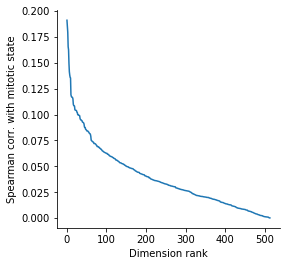

In [646]:
plt.figure(figsize=(4,4))

g = sns.lineplot(
    x=mito_corrs.abs().rank(ascending=False)["mito_state_int"],
    y=mito_corrs.abs()["mito_state_int"]
);

g.set(
#     xlim=(-5, 3),
#     ylim=(-4, 5),
    xlabel="Dimension rank",
    ylabel="Spearman corr. with mitotic state",
);

sns.despine()

plt.savefig('mito_dims_ranked.png', dpi=300, bbox_inches = "tight")

In [566]:
top_mito_dims = list(mito_corrs.abs().squeeze().sort_values().index)
top_mito_dims.reverse()

In [604]:
mito_dims_compared_to_overall_mu_ranks = [
    (dim, i, top_mu_dims.index(dim))
    for i, dim in enumerate(top_mito_dims[:8])]

mito_dims_compared_to_overall_mu_ranks

[('mu_452', 0, 9),
 ('mu_419', 1, 1),
 ('mu_465', 2, 3),
 ('mu_400', 3, 39),
 ('mu_283', 4, 351),
 ('mu_68', 5, 16),
 ('mu_510', 6, 5),
 ('mu_422', 7, 347)]

In [607]:
pd.DataFrame(mito_dims_compared_to_overall_mu_ranks, columns=["dim", "mito rank", "overall rank"])

,dim,mito rank,overall rank
0,mu_452,0,9
1,mu_419,1,1
2,mu_465,2,3
3,mu_400,3,39
4,mu_283,4,351
5,mu_68,5,16
6,mu_510,6,5
7,mu_422,7,347


## plots

In [762]:
df_embeddings_plus_meta_test_pretty_names = df_embeddings_plus_meta_test.rename(
    columns={
        "mito_state_resolved": "Mitotic state",
        'dna_volume': 'DNA volume',
        'cell_volume': 'Cell volume',
        'dna_height': 'DNA height',
        'cell_height': 'Cell height'
    }
)

pixel_length_in_micrometers = 0.29
df_embeddings_plus_meta_test_pretty_names['DNA volume (μm^3)'] = df_embeddings_plus_meta_test_pretty_names['DNA volume']*(pixel_length_in_micrometers**3)
df_embeddings_plus_meta_test_pretty_names['DNA height (μm)'] = df_embeddings_plus_meta_test_pretty_names['DNA height']*pixel_length_in_micrometers
df_embeddings_plus_meta_test_pretty_names['Cell volume (μm^3)'] = df_embeddings_plus_meta_test_pretty_names['Cell volume']*(pixel_length_in_micrometers**3)
df_embeddings_plus_meta_test_pretty_names['Cell height (μm)'] = df_embeddings_plus_meta_test_pretty_names['Cell height']*pixel_length_in_micrometers

### mito plots

#### by top 2 dims that separate mito states

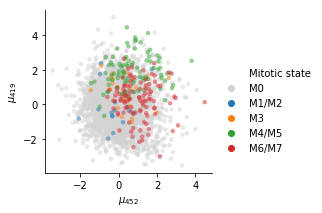

In [820]:
plt.figure(figsize=(3,3))

plt_mito = sns.scatterplot(
    data=df_embeddings_plus_meta_test_pretty_names[
        df_embeddings_plus_meta_test_pretty_names["Mitotic state"] != 'u'
    ].sort_values(
        by="Mitotic state"
    ),
    x="mu_452",
    y="mu_419",
    hue="Mitotic state",
    hue_order=['M0', 'M1/M2', 'M3', 'M4/M5', 'M6/M7'],
    palette=[("lightgrey")] + sns.color_palette("tab10")[:4],
    linewidth=0,
    alpha = 0.5,
    s=20,
)

plt_mito.set(
    xlabel="$\mu_{452}$",
    ylabel="$\mu_{419}$",
);

plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

plt.savefig('latent_plot_mito_top_mito_dims.png', dpi=300, bbox_inches = "tight")

#### by top two overall dims

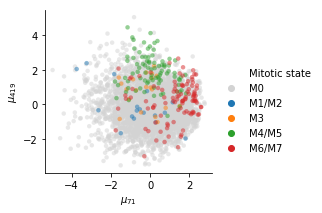

In [823]:
plt.figure(figsize=(3,3))

plt_mito = sns.scatterplot(
    data=df_embeddings_plus_meta_test_pretty_names[
        df_embeddings_plus_meta_test_pretty_names["Mitotic state"] != 'u'
    ].sort_values(
        by="Mitotic state"
    ),
    x="mu_71",
    y="mu_419",
    hue="Mitotic state",
    hue_order=['M0', 'M1/M2', 'M3', 'M4/M5', 'M6/M7'],
    palette=[("lightgrey")] + sns.color_palette("tab10")[:4],
    linewidth=0,
    alpha = 0.5,
    s=20,
)

plt_mito.set(
    xlabel="$\mu_{71}$",
    ylabel="$\mu_{419}$",
);

plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

plt.savefig('latent_plot_mito_top_mu_overall_dims.png', dpi=300, bbox_inches = "tight")

### grid plots

In [765]:
pretty_hue_names = {
    'DNA volume (μm^3)': 'DNA volume (μm$^3$)',
    'DNA height (μm)': 'DNA height (μm)',
    'Cell volume (μm^3)': 'Cell volume (μm$^3$)',
    'Cell height (μm)': 'Cell height (μm)',
}

In [737]:
pretty_mu_names = {
    'mu_71': "$\mu_{71}$",
    'mu_419': "$\mu_{419}$",
    'mu_188': "$\mu_{188}$",
    'mu_465': "$\mu_{465}$",
}
pretty_mu_names

{'mu_71': '$\\mu_{71}$',
 'mu_419': '$\\mu_{419}$',
 'mu_188': '$\\mu_{188}$',
 'mu_465': '$\\mu_{465}$'}

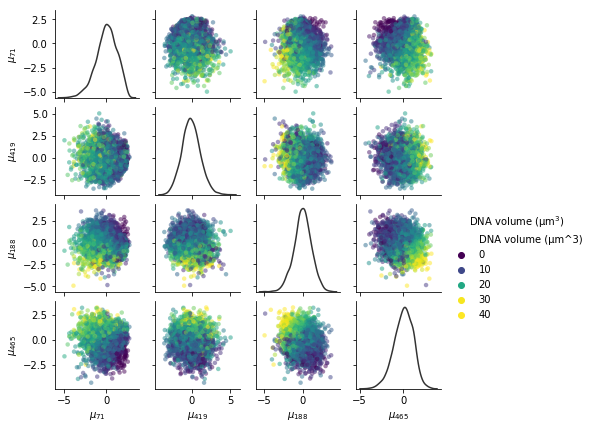

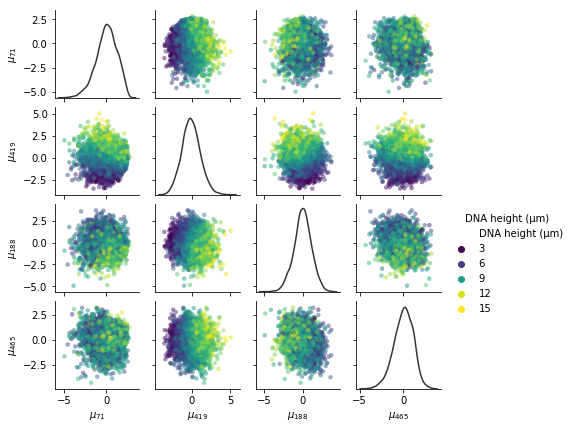

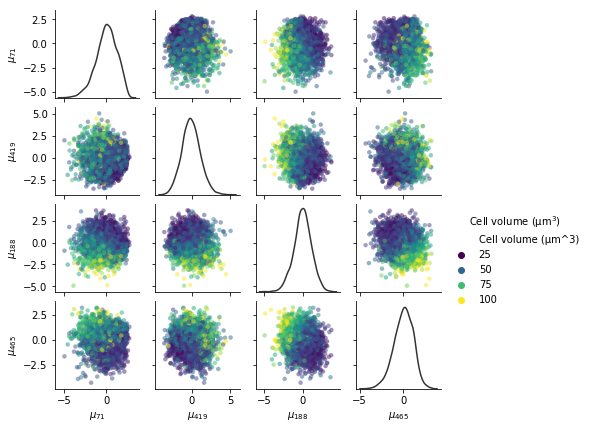

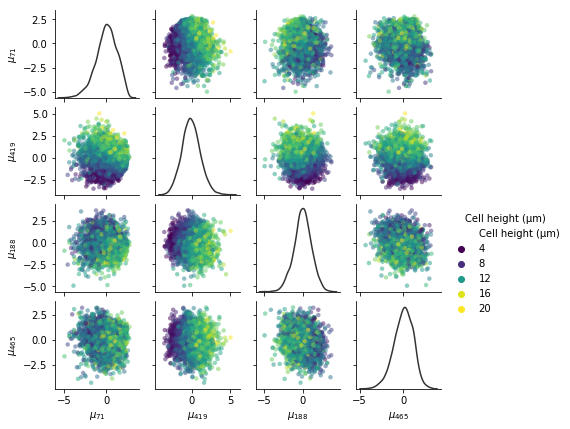

In [824]:
for hue, hue_pretty_name in pretty_hue_names.items():

    hue_norm_tail = 0.01

    df_plot = df_embeddings_plus_meta_test_pretty_names[
        df_embeddings_plus_meta_test_pretty_names["Mitotic state"] != 'u'
    ]

    g = sns.PairGrid(
        df_plot,
        height=1.5,
        vars=top_mu_dims[:4]
    )
    g.map_diag(sns.kdeplot, color=".2", shade=False)
    g.map_offdiag(
        sns.scatterplot,
        hue=df_plot[hue],
        palette="viridis",
        s=20,
        linewidth=0,
        alpha=0.5,
        hue_norm=(np.quantile(df_plot[hue], hue_norm_tail), np.quantile(df_plot[hue], 1-hue_norm_tail))
    );

    plt.legend(title=hue_pretty_name, bbox_to_anchor=(1.01, 1), frameon=False)
#     g._legend.set_title(new_title)
    
    for i in range(4):
        for j in range(4):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in pretty_mu_names.keys():
                g.axes[i][j].set_xlabel(pretty_mu_names[xlabel])
            if ylabel in pretty_mu_names.keys():
                g.axes[i][j].set_ylabel(pretty_mu_names[ylabel])
    
    
    plt.subplots_adjust(top=0.95)
#     g.fig.suptitle(f"color = {hue_pretty_name}");
    g.fig.savefig(f"latent_top_mu_dims_gridplot_color_{hue.lower().replace(' ', '_')}.png", dpi=300, bbox_inches = "tight")

### cell volume and height solo for main figure

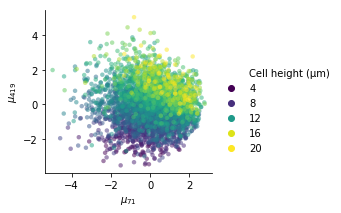

In [819]:
plt.figure(figsize=(3,3))

hue_norm_tail = 0.01

plt_mito = sns.scatterplot(
    data=df_embeddings_plus_meta_test_pretty_names[
        df_embeddings_plus_meta_test_pretty_names["Mitotic state"] != 'u'
    ].sort_values(
        by="Cell height (μm)"
    ),
    x="mu_71",
    y="mu_419",
    hue="Cell height (μm)",
    palette="viridis",
    linewidth=0,
    alpha = 0.5,
    s=20,
    hue_norm=(
        np.quantile(df_embeddings_plus_meta_test_pretty_names["Cell height (μm)"], hue_norm_tail),
        np.quantile(df_embeddings_plus_meta_test_pretty_names["Cell height (μm)"], 1-hue_norm_tail)
    )
)

plt_mito.set(
    xlabel="$\mu_{71}$",
    ylabel="$\mu_{419}$",
);

plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

plt.savefig('latent_plot_mito_cell_height_alone.png', dpi=300, bbox_inches = "tight")

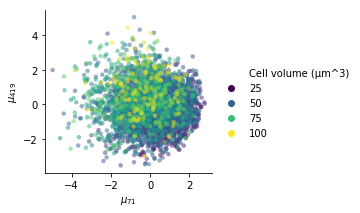

In [818]:
plt.figure(figsize=(3,3))

plt_mito = sns.scatterplot(
    data=df_embeddings_plus_meta_test_pretty_names[
        df_embeddings_plus_meta_test_pretty_names["Mitotic state"] != 'u'
    ].sort_values(
        by="Cell volume (μm^3)"
    ),
    x="mu_71",
    y="mu_419",
    hue="Cell volume (μm^3)",
    palette="viridis",
    linewidth=0,
    alpha = 0.5,
    s=20,
    hue_norm=(
        np.quantile(df_embeddings_plus_meta_test_pretty_names["Cell volume (μm^3)"], hue_norm_tail),
        np.quantile(df_embeddings_plus_meta_test_pretty_names["Cell volume (μm^3)"], 1-hue_norm_tail)
    )
)

plt_mito.set(
    xlabel="$\mu_{71}$",
    ylabel="$\mu_{419}$",
);

plt.legend(bbox_to_anchor=(1.0, 0.7), frameon=False)
sns.despine()

plt.savefig('latent_plot_mito_cell_volume_alone.png', dpi=300, bbox_inches = "tight")

## for the top N latent dims, find the top features correlated with them

In [371]:
mu_cols = [c for c in df_embeds_test.columns if c.startswith("mu_") and c != "CellId"]
feat_cols = [c for c in df_feats_all.columns if (c.startswith("dna_") or c.startswith("cell_"))]
corrs_all = df_embeddings_plus_meta_test_all_feats[mu_cols+feat_cols].corr(method="spearman")

In [375]:
corrs_all_cross = corrs_all.drop(mu_cols, axis="rows").drop(feat_cols, axis="columns")

In [582]:
top_mu_dims = list(
    df_embeddings_plus_meta_test[mu_cols].abs().mean().sort_values().index
)
top_mu_dims.reverse()

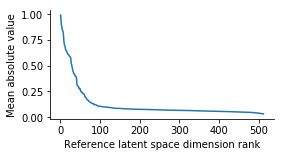

In [836]:
plt.figure(figsize=(4,2))

g = sns.lineplot(
    x=df_embeddings_plus_meta_test[mu_cols].abs().mean().rank(ascending=False),
    y=df_embeddings_plus_meta_test[mu_cols].abs().mean()
);

g.set(
#     xlim=(-5, 3),
#     ylim=(-4, 5),
    xlabel="Reference latent space dimension rank",
    ylabel="Mean absolute value",
);
sns.despine()

plt.savefig('mu_overall_dims_ranked.png', dpi=300, bbox_inches = "tight")

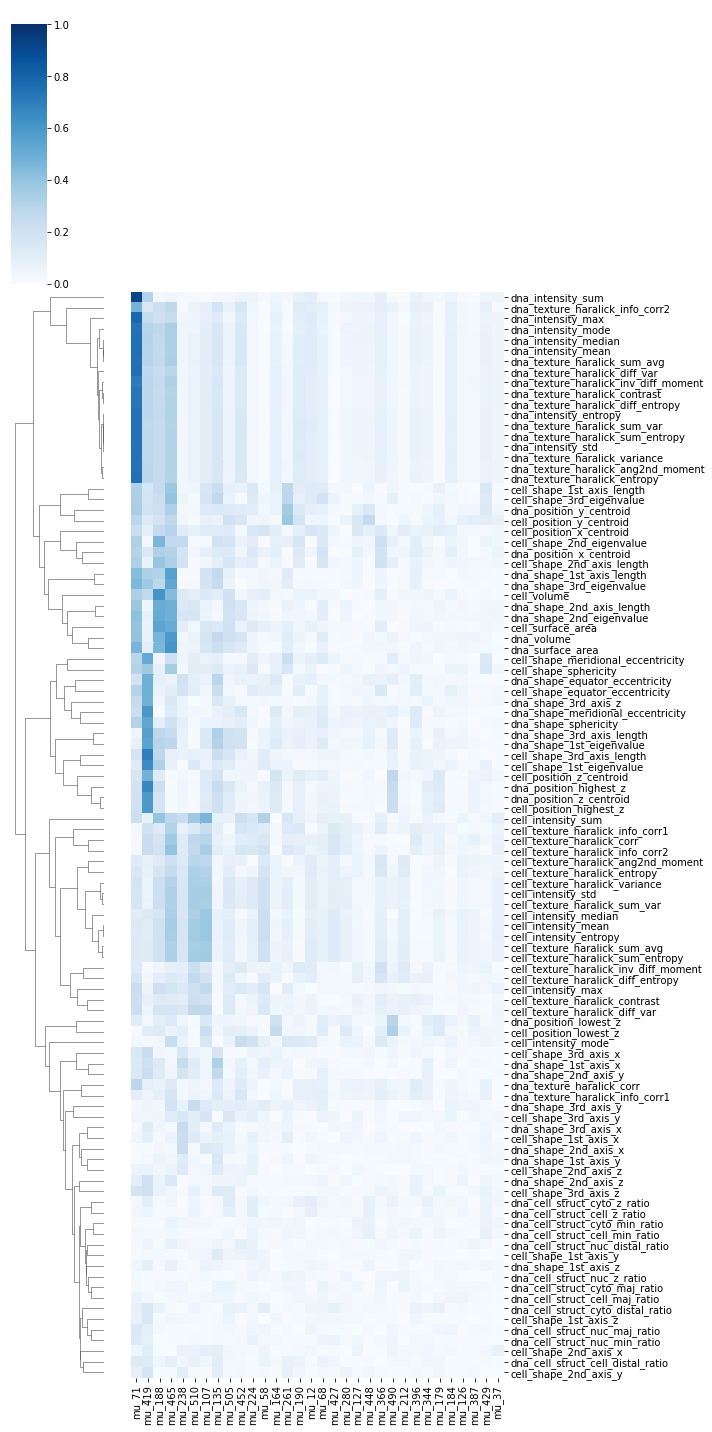

In [656]:
g = sns.clustermap(
    corrs_all_cross[top_mu_dims[:32]].abs(),
    col_cluster=False,
    figsize=(10,20),
    cmap="Blues",
    vmin=0,
#     center=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
);

g.savefig(f"heatmap_mu_vs_feats_vertical.png", dpi=300, bbox_inches = "tight")

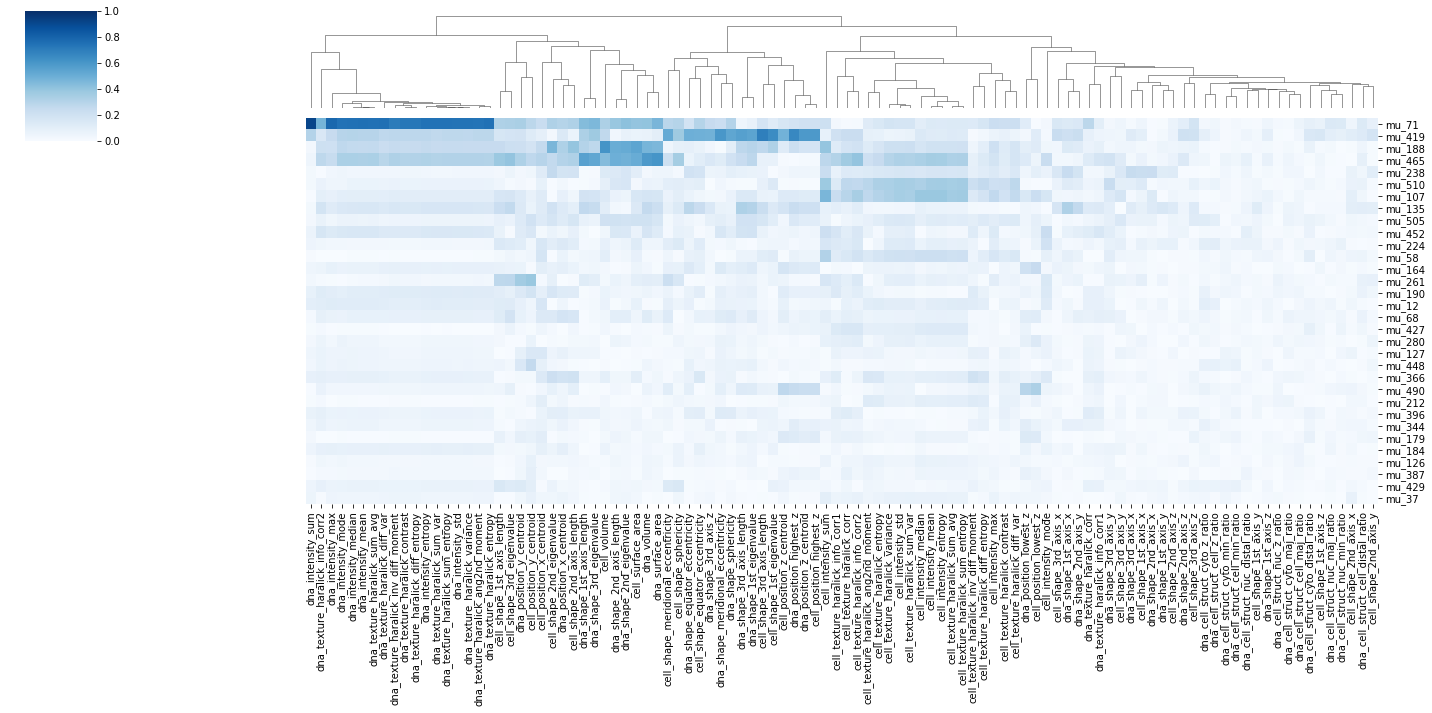

In [657]:
g = sns.clustermap(
    corrs_all_cross[top_mu_dims[:32]].T.abs(),
    row_cluster=False,
    figsize=(20,10),
    cmap="Blues",
    vmin=0,
#     center=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
);
g.savefig(f"heatmap_mu_vs_feats_horizontal.png", dpi=300, bbox_inches = "tight")

In [448]:
N_latent_dims = 8
K_feats_per_dim = 3

mu_feat_match_dict = {}
for c in corrs_all_cross[top_mu_dims[:N_latent_dims]].columns:
    top_dims_for_c = list(corrs_all_cross[top_mu_dims][c].abs().sort_values()[-K_feats_per_dim:].index)
    top_dims_for_c.reverse()
    mu_feat_match_dict[c] = top_dims_for_c
    
df_mu_feat_match = pd.DataFrame(mu_feat_match_dict)

In [449]:
df_mu_feat_match

,mu_71,mu_419,mu_465,mu_188,mu_238,mu_107,mu_510,mu_135
0,dna_intensity_sum,cell_shape_3rd_axis_length,dna_surface_area,cell_volume,cell_shape_2nd_eigenvalue,cell_intensity_sum,cell_intensity_sum,dna_shape_3rd_axis_length
1,dna_intensity_max,dna_position_highest_z,dna_volume,cell_surface_area,dna_shape_3rd_axis_x,cell_intensity_entropy,cell_intensity_entropy,dna_shape_1st_axis_x
2,dna_texture_haralick_diff_var,cell_shape_1st_eigenvalue,dna_shape_1st_axis_length,dna_shape_2nd_eigenvalue,dna_shape_1st_axis_x,cell_intensity_mean,cell_texture_haralick_sum_entropy,dna_shape_1st_eigenvalue


## draw samples from latent space along top N interesting dimensions

mu_71, top feature = dna_intensity_sum


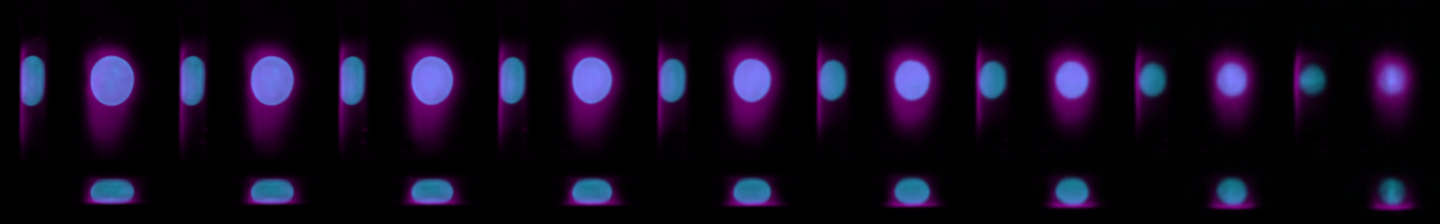


mu_419, top feature = cell_shape_3rd_axis_length


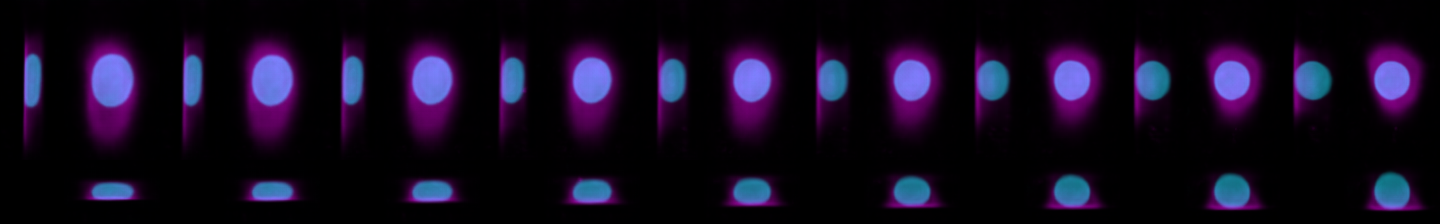


mu_465, top feature = dna_surface_area


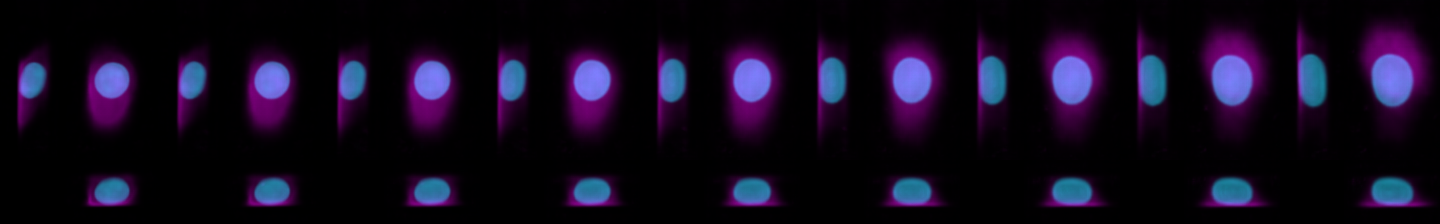


mu_188, top feature = cell_volume


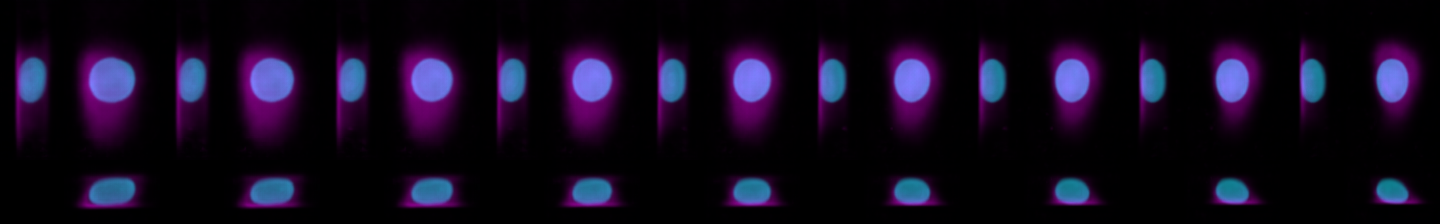


mu_238, top feature = cell_shape_2nd_eigenvalue


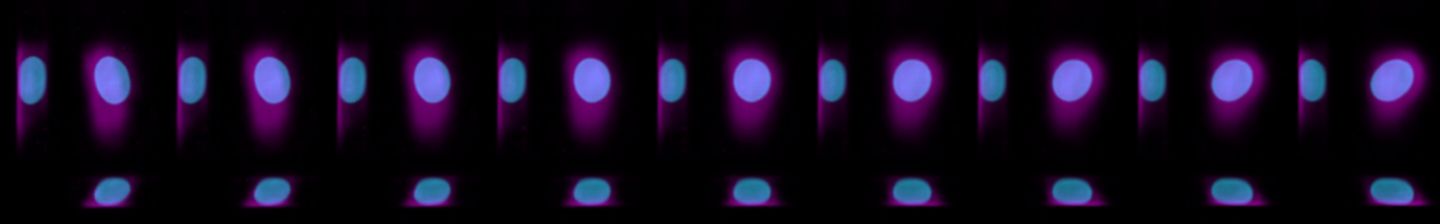


mu_107, top feature = cell_intensity_sum


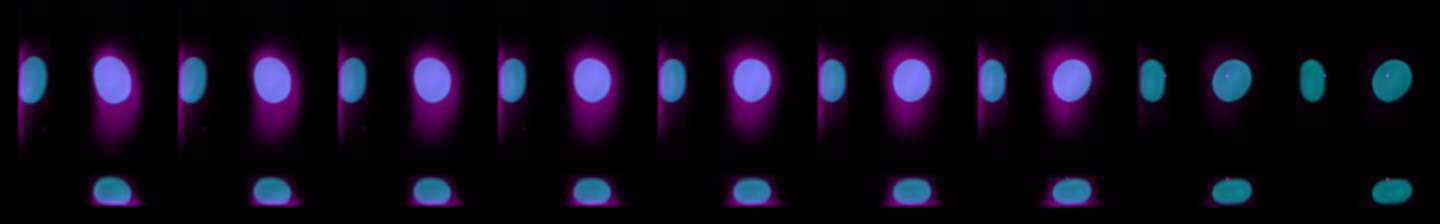


mu_510, top feature = cell_intensity_sum


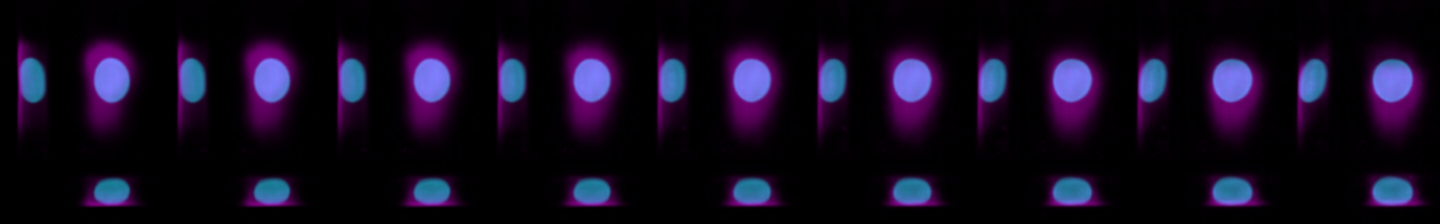


mu_135, top feature = dna_shape_3rd_axis_length


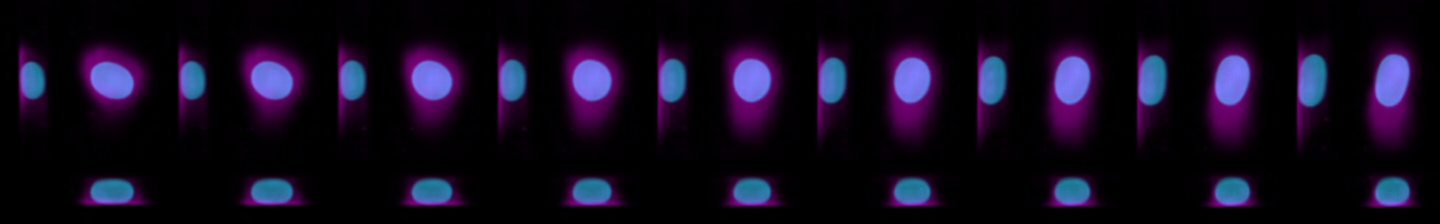

In [599]:
for dim in df_mu_feat_match.columns:
    int_dim = int(dim.split("_")[-1])
    top_feat_for_dim = df_mu_feat_match.loc[0, dim]
    
    latent_walk_path = np.float32(df_embeds[dim].std()*np.linspace(-2,2,9))
    latent_walk_path = torch.from_numpy(latent_walk_path)

    latent_input = torch.zeros([len(latent_walk_path), 512], dtype=torch.float32)
    latent_input[:,int_dim] = latent_walk_path
    latent_input = latent_input.cuda()
    
    walk_output = ref_dec(latent_input)
    walk_output = walk_output.cpu().data
    walk_im = tensor2im(walk_output)
    
    pil_im = Image.fromarray(np.uint8(walk_im*255))
    pil_im.save(f"latent_walk_{dim}_top_feat_{top_feat_for_dim}.png","PNG")
    
    print(f"{dim}, top feature = {top_feat_for_dim}")
    display(pil_im)
    print("")

In [828]:
df_embeds[["mu_71", "mu_419"]].std()

mu_71     1.276870
mu_419    1.221874
dtype: float32

In [673]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [674]:
pca = PCA()
pca.fit(scale(df_feats_all[feat_cols].dropna()))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

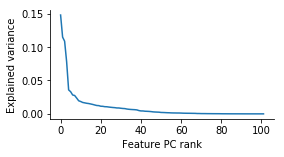

In [842]:
plt.figure(figsize=(4,2))

g = sns.lineplot(
    x=pd.DataFrame(
        pca.explained_variance_ratio_, columns=["Feature PCA explained variance"]
    ).index,
    y=pd.DataFrame(
        pca.explained_variance_ratio_, columns=["Feature PCA explained variance"]
    )["Feature PCA explained variance"]
);

g.set(
#     xlim=(0, 12),
#     ylim=(-4, 5),
    xlabel="Feature PC rank",
    ylabel="Explained variance",
);
sns.despine()

plt.savefig('pca_feats_explained_variance.png', dpi=300, bbox_inches = "tight")

In [840]:
pd.DataFrame(
    np.cumsum(pca.explained_variance_ratio_), columns=[
    "Feature PCA explained variance"
    ]
)["Feature PCA explained variance"]

0      0.148022
1      0.262980
2      0.371790
3      0.449956
4      0.485860
         ...   
97     0.999999
98     1.000000
99     1.000000
100    1.000000
101    1.000000
Name: Feature PCA explained variance, Length: 102, dtype: float64

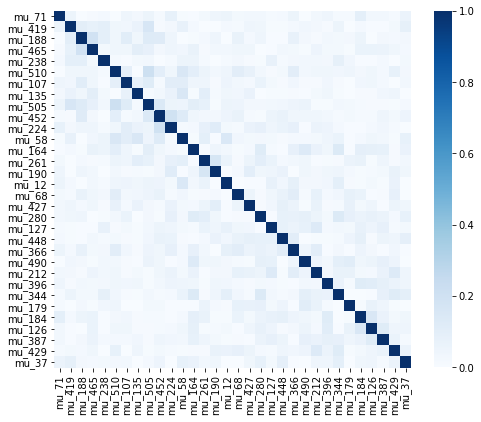

In [831]:
mu_corrs = df_embeddings_plus_meta_test_all_feats[top_mu_dims[:32]].corr()

plt.figure(figsize=(8,8))
g = sns.heatmap(
    mu_corrs.abs(),
    cmap="Blues",
    vmin=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    square=True,
    cbar_kws={"shrink": .82}
)

plt.savefig('latent_dim_corrs.png', dpi=300, bbox_inches = "tight")